<a href="https://colab.research.google.com/github/PangyourQA/Stock-Price-Prediction-CNN-BiLSTM-MTST/blob/main/MScFE_Capstone_Pang_Dhawal_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Validation

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 107ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


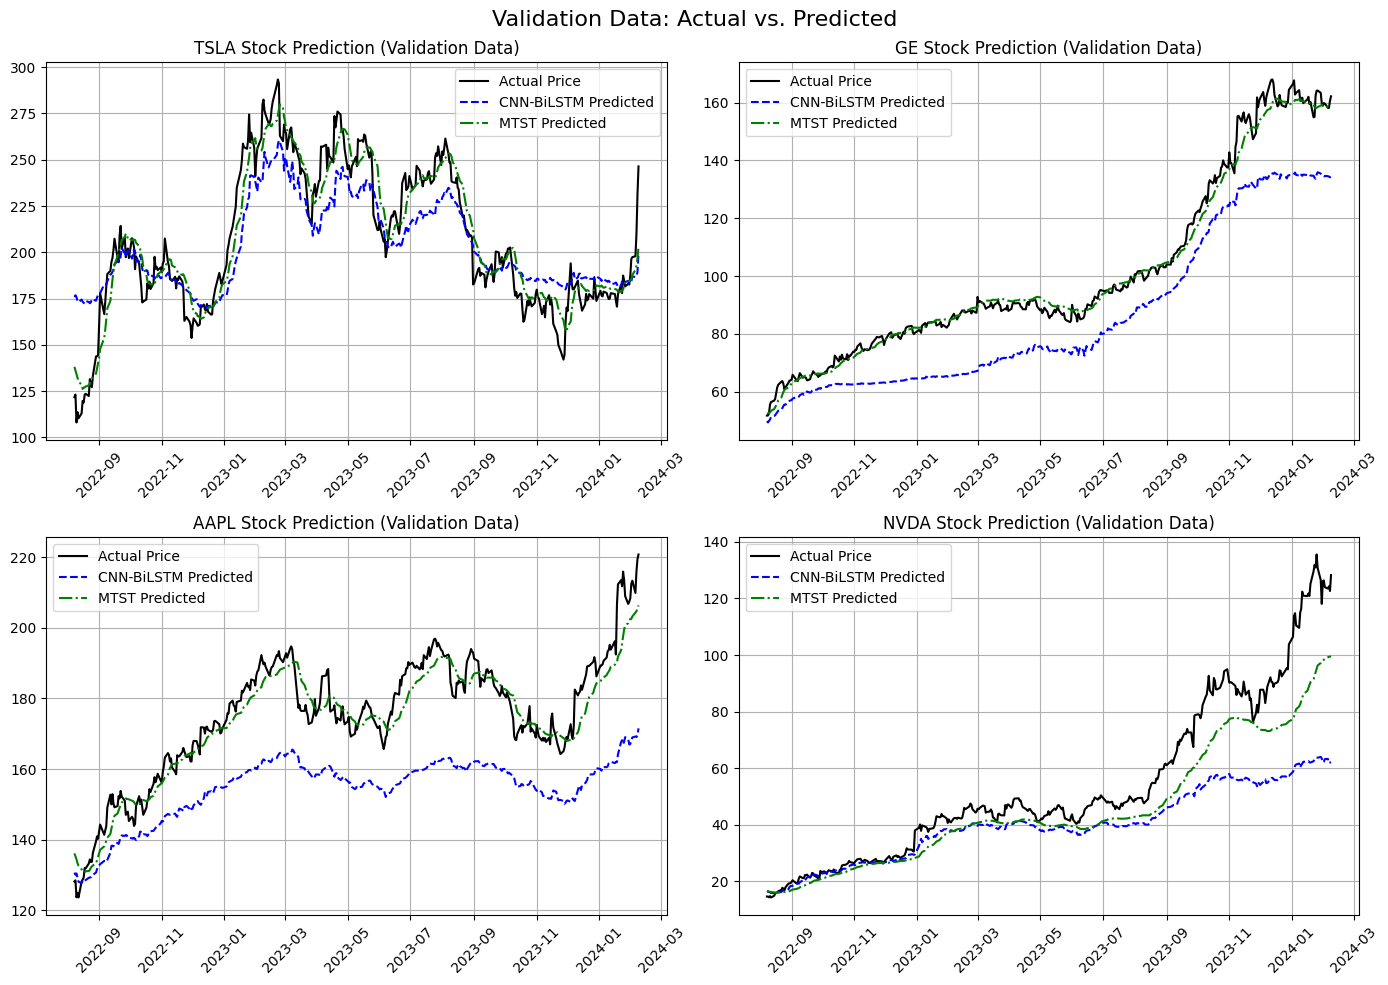

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Bidirectional, Dropout, Dense, Flatten, Input, Add, MultiHeadAttention, LayerNormalization
import tensorflow as tf

# Function Definitions (Same as Before) ...
# Custom Early Stopping
class CustomEarlyStopping(tf.keras.callbacks.EarlyStopping):
    def __init__(self, min_epoch=0, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.min_epoch = min_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch < self.min_epoch:
            return  # Skip early stopping logic before min_epoch
        super().on_epoch_end(epoch, logs)

def fetch_stock_data(ticker):
    df = yf.download(ticker, start="2015-01-01", end="2025-01-01")
    df = df[['Close']]
    return df

def preprocess_data(df):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    testing_data_len = int(len(df) * 0.05)
    train_valid = scaled_data[:-testing_data_len, :]
    training_data_len = int(len(train_valid) * 0.8)

    train_data = train_valid[:training_data_len, :]
    X_train, y_train = [], []
    for i in range(100, len(train_data)):
        X_train.append(train_data[i-100:i, 0])
        y_train.append(train_data[i, 0])

    val_data = train_valid[training_data_len:, :]
    X_val, y_val = [], []
    for i in range(100, len(val_data)):
        X_val.append(val_data[i-100:i, 0])
        y_val.append(val_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_val, y_val = np.array(X_val), np.array(y_val)

    X_train = np.reshape(X_train, (X_train.shape[0], 25, 4, 1))
    X_val = np.reshape(X_val, (X_val.shape[0], 25, 4, 1))

    return scaler, X_train, y_train, X_val, y_val, train_valid, training_data_len, testing_data_len

def build_CNN_BiLSTM(input_shape):
    model = Sequential([
        tf.keras.layers.TimeDistributed(Conv1D(64, kernel_size=3, activation="relu"), input_shape=input_shape),
        tf.keras.layers.TimeDistributed(BatchNormalization()),
        tf.keras.layers.TimeDistributed(MaxPooling1D(pool_size=2)),
        tf.keras.layers.TimeDistributed(Dropout(0.2)),
        tf.keras.layers.TimeDistributed(Flatten()),
        Bidirectional(LSTM(100, activation="tanh", return_sequences=False)),
        Dropout(0.3),
        Dense(50, activation="relu"),
        Dropout(0.2),
        Dense(25, activation="relu"),
        Dense(1, activation="linear")
    ])
    model.compile(loss='mse', optimizer='adam')
    return model

def build_MTST(input_shape):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    attn_output = Dropout(0.2)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output)
    out1 = Add()([inputs, attn_output])
    lstm_out = LSTM(64, activation='tanh', return_sequences=False)(out1)
    lstm_out = Dropout(0.2)(lstm_out)
    dense_out = Dense(32, activation="relu")(lstm_out)
    dense_out = Dropout(0.2)(dense_out)
    outputs = Dense(1, activation="linear")(dense_out)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer="adam", loss="mse")
    return model

def MAPE(y_actual, y_pred):
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

# List of companies
companies = ['TSLA', 'GE', 'AAPL', 'NVDA']
results = []

fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 subplots
fig.suptitle("Validation Data: Actual vs. Predicted", fontsize=16)
axes = axes.flatten()

for i, company in enumerate(companies):
    df = fetch_stock_data(company)
    scaler, X_train, y_train, X_val, y_val, train_valid, training_data_len, testing_data_len = preprocess_data(df)

    model_CNN_Bilstm = build_CNN_BiLSTM((None, X_train.shape[2], X_train.shape[3]))
    model_MTST = build_MTST((X_train.shape[1], X_train.shape[2]))

    early_stopping = CustomEarlyStopping(min_epoch=15, monitor='val_loss', patience=15, min_delta=1e-5, restore_best_weights=True)

    model_CNN_Bilstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stopping], verbose=0)
    model_MTST.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, callbacks=[early_stopping], verbose=0)

    model_CNN_Bilstm.save(f'CNN_BiLSTM_{company}.keras')
    model_MTST.save(f'MTST_{company}.keras')

    # 🛠️ Use Validation Data Instead of Test Data
    predictions_CNN_BiLSTM = scaler.inverse_transform(model_CNN_Bilstm.predict(X_val))
    predictions_MTST = scaler.inverse_transform(model_MTST.predict(X_val).reshape(-1, 1))

    actual_prices = scaler.inverse_transform(y_val.reshape(-1, 1))

    # 🗓️ Get the real dates for validation data
    val_dates = df.index[training_data_len: training_data_len + len(y_val)]

    # Store results
    results.append([
        company,
        np.sqrt(np.mean((predictions_CNN_BiLSTM - actual_prices) ** 2)),
        MAPE(actual_prices, predictions_CNN_BiLSTM),
        np.sqrt(np.mean((predictions_MTST - actual_prices) ** 2)),
        MAPE(actual_prices, predictions_MTST)
    ])

    # 📈 Plot Actual vs. Predicted Prices on Validation Data
    axes[i].plot(val_dates, actual_prices, label="Actual Price", color='black')
    axes[i].plot(val_dates, predictions_CNN_BiLSTM, label="CNN-BiLSTM Predicted", linestyle='--', color='blue')
    axes[i].plot(val_dates, predictions_MTST, label="MTST Predicted", linestyle='-.', color='green')
    axes[i].set_title(f"{company} Stock Prediction (Validation Data)")
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis='x', rotation=45)  # Rotate date labels for readability

# Save to Excel
results_df = pd.DataFrame(results, columns=['Company', 'RMSE_CNN_BiLSTM', 'MAPE_CNN_BiLSTM', 'RMSE_MTST', 'MAPE_MTST'])
results_df.to_excel('validation_results.xlsx', index=False)

# Save and Show PNG
fig.tight_layout()
fig.savefig("validation_predicted_vs_actual.png")  # Save PNG file
plt.show()

### Backtesting

[*********************100%***********************]  1 of 1 completed

Processing TSLA...


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


[*********************100%***********************]  1 of 1 completed

Processing GE...


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


[*********************100%***********************]  1 of 1 completed

Processing AAPL...


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


[*********************100%***********************]  1 of 1 completed

Processing NVDA...


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Test results saved to 'test_results.xlsx'


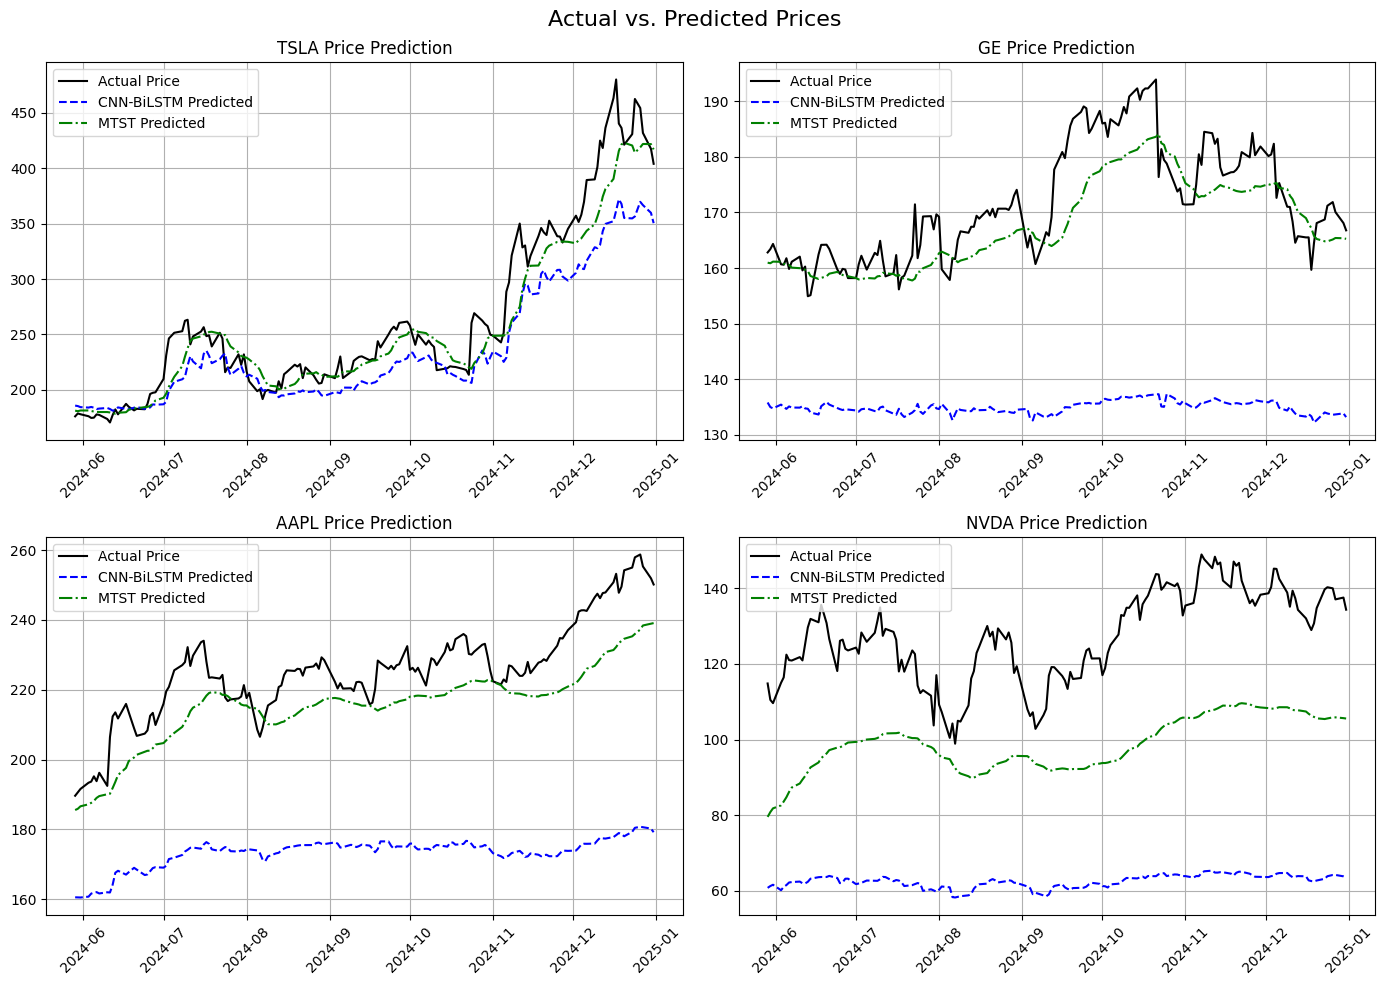

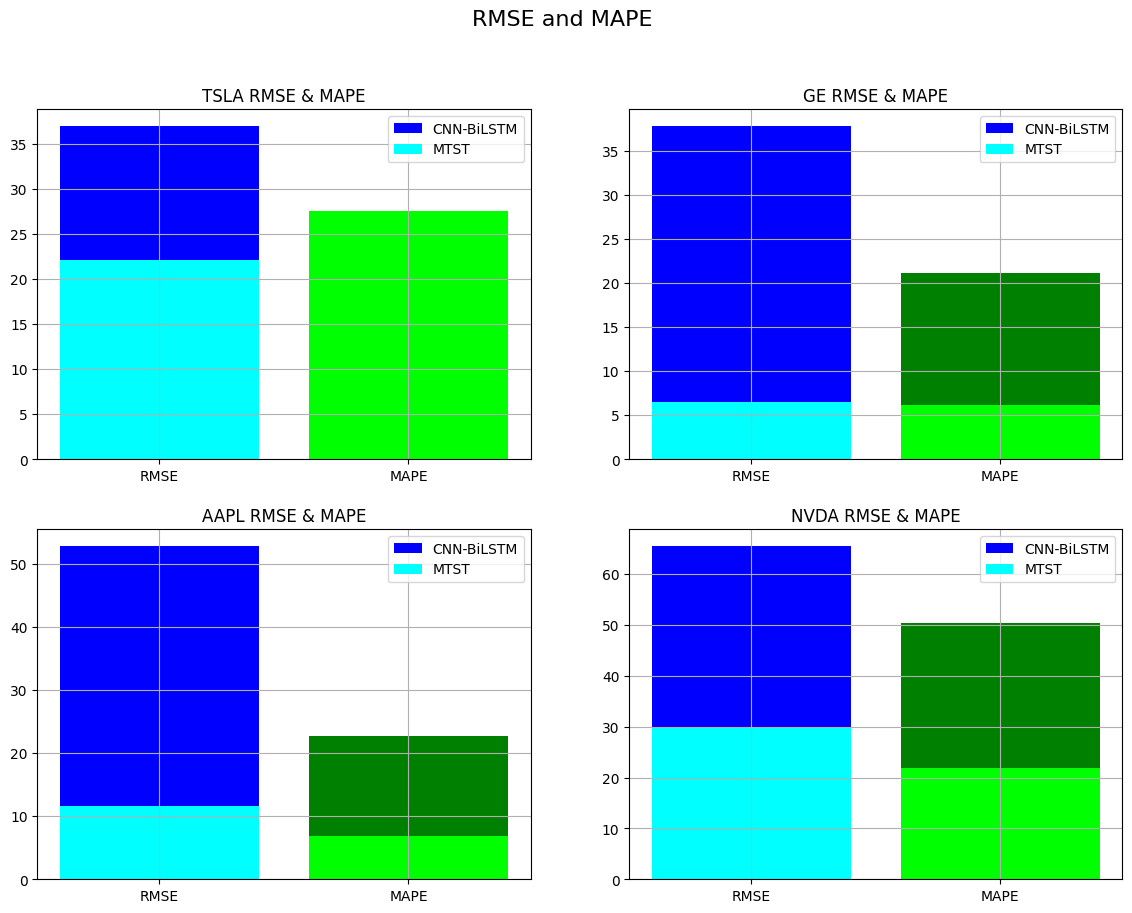

In [87]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

def calculate_mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100

# ✅ List of companies
companies = ['TSLA', 'GE', 'AAPL', 'NVDA']
writer = pd.ExcelWriter('test_results.xlsx', engine='openpyxl')  # ✅ Fix Excel writer issue

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
fig1.suptitle("Actual vs. Predicted Prices", fontsize=16)
axes1 = axes1.flatten()

fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
fig2.suptitle("RMSE and MAPE", fontsize=16)
axes2 = axes2.flatten()

for i, company in enumerate(companies):
    print(f"Processing {company}...")
    df = yf.download(company, start="2015-01-01", end="2025-01-01")[['Close']]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

    testing_data_len = int(len(df) * 0.05)
    test_data = scaled_data[-(2*testing_data_len):]

    # ✅ Ensure X_test has the right shape
    X_test = np.array([test_data[j-100:j, 0] for j in range(100, len(test_data))])
    X_test = X_test.reshape(-1, 25, 4, 1)

    # ✅ Ensure y_test matches the number of predictions
    y_test = df['Close'].iloc[-len(X_test):].values

    # ✅ Get real dates for testing period
    test_dates = pd.to_datetime(df.index[-len(y_test):])  # Convert to DatetimeIndex

    # ✅ Load trained models
    model_CNN_BiLSTM = load_model(f'CNN_BiLSTM_{company}.keras')
    model_MTST = load_model(f'MTST_{company}.keras')

    # ✅ Generate predictions & reshape correctly
    predicted_CNN_BiLSTM = scaler.inverse_transform(model_CNN_BiLSTM.predict(X_test)).flatten()
    predicted_MTST = scaler.inverse_transform(model_MTST.predict(X_test).reshape(-1, 1)).flatten()

    # ✅ Trim predictions if necessary
    predicted_CNN_BiLSTM = predicted_CNN_BiLSTM[:len(y_test)]
    predicted_MTST = predicted_MTST[:len(y_test)]

    # ✅ Calculate RMSE & MAPE
    rmse_CNN = np.sqrt(mean_squared_error(y_test, predicted_CNN_BiLSTM))
    mape_CNN = calculate_mape(y_test, predicted_CNN_BiLSTM)

    rmse_MTST = np.sqrt(mean_squared_error(y_test, predicted_MTST))
    mape_MTST = calculate_mape(y_test, predicted_MTST)

    # ✅ Save to Excel (real dates included)
    result_df = pd.DataFrame({
        "Date": test_dates[:len(y_test)],  # ✅ Match dates with y_test
        "Actual Price": y_test.flatten(),
        "CNN-BiLSTM Predicted": predicted_CNN_BiLSTM,
        "MTST Predicted": predicted_MTST,
    })

    result_df.to_excel(writer, sheet_name=company, index=False)

    # ✅ Plot Actual vs. Predicted Prices
    axes1[i].plot(test_dates[:len(y_test)], y_test, label="Actual Price", color='black')
    axes1[i].plot(test_dates[:len(y_test)], predicted_CNN_BiLSTM, label="CNN-BiLSTM Predicted", linestyle='--', color='blue')
    axes1[i].plot(test_dates[:len(y_test)], predicted_MTST, label="MTST Predicted", linestyle='-.', color='green')
    axes1[i].set_title(f"{company} Price Prediction")
    axes1[i].legend()
    axes1[i].grid()
    axes1[i].tick_params(axis='x', rotation=45)  # ✅ Rotate x-axis for better readability

    # ✅ Plot RMSE and MAPE
    axes2[i].bar(["RMSE", "MAPE"], [rmse_CNN, mape_CNN], color=['blue', 'green'], label="CNN-BiLSTM")
    axes2[i].bar(["RMSE", "MAPE"], [rmse_MTST, mape_MTST], color=['cyan', 'lime'], label="MTST")
    axes2[i].set_title(f"{company} RMSE & MAPE")
    axes2[i].legend()
    axes2[i].grid()

# ✅ Save Excel file
writer.close()
print("Test results saved to 'test_results.xlsx'")

# ✅ Save and show the final plots
fig1.tight_layout()
fig1.savefig("actual_vs_predicted.png")
plt.show()

fig2.tight_layout()
fig2.savefig("performance_metrics.png")
plt.show()